In [1]:
from omtra.load.quick import datamodule_from_config
import omtra.load.quick as quick_load
from omtra.utils import omtra_root
from rdkit import Chem
from pathlib import Path
from omtra.constants import num_condensed_atom_types
from omtra.data.condensed_atom_typing import CondensedAtomTyper
import torch

from omtra.tasks.register import task_name_to_class
import rdkit
from rdkit import Chem
import py3Dmol
rdkit.Chem.Draw.IPythonConsole.ipython_3d = True  # enable py3Dmol inline visualization

/home/ruh/miniconda3/envs/dgl_build_arch_121/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ruh/miniconda3/envs/dgl_build_arch_121/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/ruh/miniconda3/envs/dgl_build_arch_121/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedF

In [2]:
from lightning.pytorch import seed_everything
seed_everything(42)

Seed set to 42


42

In [3]:
import torch.nn.functional as F

In [4]:
def get_task_capabilities(task_name):
  """
  Determine what modalities a task supports based on its groups.

  Returns:
      dict: Dictionary with boolean flags for each modality
  """
  task_class = task_name_to_class(task_name)
  groups = task_class.groups_present

  capabilities = {
      'has_protein': any(g in groups for g in ['protein_identity', 'protein_structure']),
      'has_pharmacophore': 'pharmacophore' in groups,
      'has_ligand': any(g in groups for g in ['ligand_identity', 'ligand_identity_condensed', 'ligand_identity_extra', 'ligand_structure']),
  }

  return capabilities

In [5]:
import numpy as np
np.random.seed(0)

In [6]:
# Load model and data (your existing setup)
ckpt = '/home/ruh/research/koeslab/OMTRA/outputs/csb_runs/st_docking_weight_1_2gpus_2025-11-10_15-39-788971/checkpoints/batch_100000.ckpt'
ckpt = Path(ckpt)

cfg_file = ckpt.parent.parent / '.hydra/config.yaml'
cfg = quick_load.load_trained_model_cfg(cfg_file)
pharmit_path = "/home/ruh/data/pharmit_dev"
plinder_path = "/home/ruh/data/plinder"
cfg.pharmit_path = str(pharmit_path)
cfg.plinder_path = str(plinder_path)

model = quick_load.omtra_from_checkpoint(str(ckpt)).cuda().eval()
dm = quick_load.datamodule_from_config(cfg)
multiset = dm.load_dataset('train')
dataset = multiset.datasets['plinder']['no_links']

/home/ruh/miniconda3/envs/dgl_build_arch_121/lib/python3.11/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


In [7]:

## conformer generation (unconditional and pharm conditioned)
#task_name = 'ligand_conformer_from_pharmacophore_condensed'
#task_name = 'ligand_conformer_condensed'

## denovo task (unconditional and pharm conditioned)
#task_name = "denovo_ligand_condensed"
#task_name = "denovo_ligand_from_pharmacophore_condensed"


## ====>> tasks that have proteins: <<=====

#====> denovo
#task_name = "fixed_protein_ligand_denovo_condensed"
#task_name = 'fixed_protein_pharmacophore_ligand_denovo_condensed'

#====> docking
task_name = "rigid_docking_condensed"
# task_name = "rigid_docking_pharmacophore_condensed"


num_timesteps = 50
chosen_indices =  [443,702,152,158,190,842,441,436,65,292,852,413,861,256,39,696,259,762,602,627,546,692,509,85,266,368,191,329,761,355,466,826,177,477,146,848,710,854,743,369,18,134,223,315,322,144,280,74,533,741,694,806,203,815,780,210,34,487,424,151,672,350,235,773,10,395,313,353,67,213,77,332,540,464,409,788,688,423,853,463,475,21,758,614,90,649,68,810,531,149,428,680,179,775,59,789,855,164,482,733]
 
#[443,702,152,158,190,842,441,436,65,292,852,413,861,256,39,696,259,762,602,627]

#[443,702]#,152]

g_list = [ dataset[(task_name, i)] for i in chosen_indices ]
for i in range(len(g_list)):
    g_list[i] = g_list[i].to('cuda')

sampled_systems = model.sample(
    task_name=task_name,
    g_list=g_list,
    n_replicates=1,
    # unconditional_n_atoms_dist='plinder',
    n_timesteps=num_timesteps, 
    extract_latents_for_confidence=True, 
)

In [8]:
def get_confidence_logits(some_graph):
    atom_features = some_graph.nodes['lig'].data['node_scalar_features']  # [N_lig, 256]
    plddt_logits = model.confidence_module(atom_features.cuda())  # [N_lig, 50]

    return plddt_logits

In [9]:
# https://github.com/google-deepmind/alphafold/blob/09ed0c5d5a32d794ed9f78b70906cbeaff0ef439/alphafold/common/confidence.py

In [10]:
from omtra.utils.lddt import compute_lddt, compute_plddt

In [11]:
average_plddts = []

for each_graph in sampled_systems:
    
    plddt_logits = get_confidence_logits(each_graph.g)
    plddt = compute_plddt(plddt_logits).mean().item()

    average_plddts.append(plddt)

In [12]:
average_plddts

[98.85887908935547,
 98.78697204589844,
 98.47582244873047,
 98.83065032958984,
 98.7777328491211,
 98.76329040527344,
 97.64789581298828,
 98.8639907836914,
 98.12590026855469,
 98.88459777832031,
 98.50125122070312,
 98.78255462646484,
 98.94754791259766,
 98.73937225341797,
 98.98101806640625,
 98.86869049072266,
 98.83038330078125,
 98.46249389648438,
 97.22200012207031,
 98.8839111328125,
 97.53495788574219,
 98.93012237548828,
 98.84587860107422,
 98.23163604736328,
 97.43653869628906,
 98.80321502685547,
 98.72980499267578,
 98.98397827148438,
 98.53609466552734,
 98.8737564086914,
 98.99671936035156,
 98.994873046875,
 98.86186218261719,
 98.8520736694336,
 98.58116149902344,
 98.9687271118164,
 98.19092559814453,
 98.89826202392578,
 98.73762512207031,
 97.93289947509766,
 98.73927307128906,
 98.76115417480469,
 98.4731216430664,
 98.5951919555664,
 97.9380111694336,
 98.6501693725586,
 98.33855438232422,
 97.73058319091797,
 98.96842193603516,
 98.18406677246094,
 97.87002563

In [13]:
from omtra.tasks.modalities import name_to_modality
import torch_cluster as tc
import torch.nn.functional as F
import dgl

### now batch them again (we are hoping to lddt in batch wise now)

In [14]:
g_list = [s.g for s in sampled_systems]
g_batched = dgl.batch(g_list)

print(f"Batched graph: batch_size = {g_batched.batch_size}")
print(f"Total lig nodes: {g_batched.num_nodes('lig')}")
print(f"Total prot_atom nodes: {g_batched.num_nodes('prot_atom')}")

Batched graph: batch_size = 100
Total lig nodes: 3167
Total prot_atom nodes: 39512


In [15]:
plddt_logits = get_confidence_logits(g_batched)
compute_plddt(plddt_logits)

tensor([98.3325, 98.9998, 98.7759,  ..., 98.9996, 98.8412, 98.7363],
       device='cuda:0', grad_fn=<MulBackward0>)

In [16]:
from graphLayout import GraphLayout

In [17]:
layout = GraphLayout(g_batched)
padded_feats, masks = layout.graph_to_padded_sequence(g_batched)

In [18]:
node_scalar_features = padded_feats['lig']['node_scalar_features']

In [19]:
node_scalar_features.shape

torch.Size([100, 111, 256])

In [20]:
coords_true_lig_    = padded_feats['lig']['x_1_true']
coords_true_pocket_ = padded_feats['prot_atom']['x_1_true']
coords_pred_lig_    = padded_feats['lig']['x_1_pred']

In [21]:
# coords_pred_lig_, coords_true_lig_

In [22]:
mask_lig    = masks['lig']
mask_pocket = masks['prot_atom']

In [23]:
from omtra.utils.lddt import compute_lddt

#### extract out stuff we generated. if we didnt generate use the gt for that modality

In [24]:
_, lddt_scores = compute_lddt(g_batched)

# only average over real atoms (not padding)

averaged_lddt_values = []
for i in range(lddt_scores.shape[0]):
  real_atoms = lddt_scores[i][mask_lig[i]]  # Filter to real atoms only
  averaged_lddt_values.append((real_atoms.mean() * 100).item())

In [25]:
# lddt_scores.mean(dim=-1) #incorrect

In [26]:
averaged_lddt_values

[50.00593185424805,
 74.69844055175781,
 34.81796646118164,
 28.010828018188477,
 74.41040802001953,
 47.67564392089844,
 33.13152313232422,
 38.32284927368164,
 31.55388832092285,
 74.6064224243164,
 45.11957931518555,
 39.44120407104492,
 25.877063751220703,
 65.43624114990234,
 84.6924819946289,
 53.20293426513672,
 48.73298263549805,
 38.53369903564453,
 41.99510955810547,
 65.72871398925781,
 31.115631103515625,
 24.567907333374023,
 65.93476104736328,
 49.70619201660156,
 22.407140731811523,
 76.0753173828125,
 23.28272819519043,
 82.67460632324219,
 28.451160430908203,
 53.834388732910156,
 55.21275329589844,
 63.21574401855469,
 48.22904968261719,
 82.09159088134766,
 18.269365310668945,
 85.53947448730469,
 42.48592758178711,
 57.66435241699219,
 24.347423553466797,
 40.48220443725586,
 64.5047378540039,
 42.829288482666016,
 44.125152587890625,
 26.9799747467041,
 38.48284912109375,
 46.80195617675781,
 38.97085189819336,
 39.999568939208984,
 51.86567306518555,
 35.662307739

In [27]:
average_plddts

[98.85887908935547,
 98.78697204589844,
 98.47582244873047,
 98.83065032958984,
 98.7777328491211,
 98.76329040527344,
 97.64789581298828,
 98.8639907836914,
 98.12590026855469,
 98.88459777832031,
 98.50125122070312,
 98.78255462646484,
 98.94754791259766,
 98.73937225341797,
 98.98101806640625,
 98.86869049072266,
 98.83038330078125,
 98.46249389648438,
 97.22200012207031,
 98.8839111328125,
 97.53495788574219,
 98.93012237548828,
 98.84587860107422,
 98.23163604736328,
 97.43653869628906,
 98.80321502685547,
 98.72980499267578,
 98.98397827148438,
 98.53609466552734,
 98.8737564086914,
 98.99671936035156,
 98.994873046875,
 98.86186218261719,
 98.8520736694336,
 98.58116149902344,
 98.9687271118164,
 98.19092559814453,
 98.89826202392578,
 98.73762512207031,
 97.93289947509766,
 98.73927307128906,
 98.76115417480469,
 98.4731216430664,
 98.5951919555664,
 97.9380111694336,
 98.6501693725586,
 98.33855438232422,
 97.73058319091797,
 98.96842193603516,
 98.18406677246094,
 97.87002563

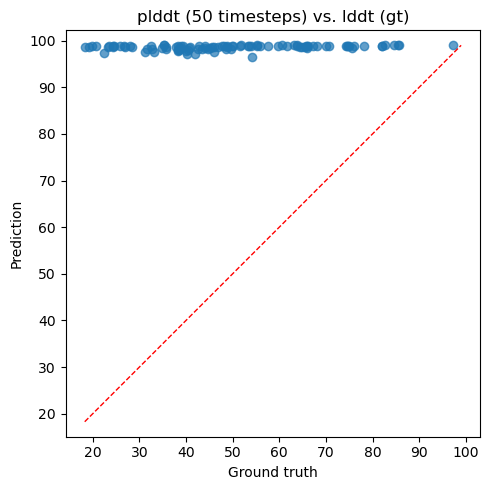

In [34]:
import matplotlib.pyplot as plt

# groundtruth and predictions are lists/arrays of equal length
plt.figure(figsize=(5,5))
plt.scatter(averaged_lddt_values, average_plddts, alpha=0.7)

# identity line
mn = min(min(averaged_lddt_values), min(average_plddts))
mx = max(max(averaged_lddt_values), max(average_plddts))
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)

plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.title(f"plddt ({num_timesteps} timesteps) vs. lddt (gt)")
plt.axis('equal')
plt.tight_layout()

plt.savefig(f"pred_vs_gt_timesteps{num_timesteps}.pdf")
plt.show()
